The method $\texttt{getCharacter()}\rightarrow$ retrive a dictionary over the characters of GoT. The value of each character is a dictionary containing *id*, *page*, and *house* information. These values will be filled in later.

The method $\texttt{getHouseForCharacters(characters)}$ retrieves the house information for each character, if this information can be extracted from the site. The *characters[character]['house']* value is then updated, if house information is found. 

The method $\texttt{getHouses(minCount)} \rightarrow$ Returns a dictionary, with house as key, and a dictionary containing a list of members in the house and the number of members, as value. For the houses in GoT with more than *minCount* members.

In [1]:
import json, operator, community
from urllib2 import urlopen
from bs4 import BeautifulSoup
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import cPickle as pickle
%matplotlib inline

def loadFile(filename):
    characters = pickle.load(open(filename, "rb" ))
    return characters

def saveFile(filename, content):
    pickle.dump(content, open(filename, "wb" ))
    
def prettifyName(name):
    name = name.replace('_',' ') if '_' in name else name
    return name

def getCharacters():
    characterUrl = 'http://gameofthrones.wikia.com/api/v1/Articles/List?expand=1&category=Characters&limit=10000'
    response = urlopen(characterUrl)
    html = response.read()
    j = json.loads(html)

    characters = dict()
    for i in j['items']:
        if i['type'] == 'article':
            if not i['title'].startswith("Sandbox/"):
                title = i['title'].replace(' ', '_')
                characters[title] = {'id': i['id'], 'page' : set(), 'house' : None}
    return characters

def getHouseForCharacters(characters):
    base = 'https://api.got.show/api/characters/'
    response = urlopen(base)
    html = response.read()
    chars = json.loads(html)
    for c in chars:
        name = c['name'].replace(' ', '_')
        if name in characters:
            if 'house' in c:
                characters[name]['house'] = c['house']    
    return characters

import operator
def getHouses(minCount=5):
    houses = dict()
    for k,v in characters.iteritems():
        h = v['house']
        if h != None:
            if h in houses:
                houses[h]['count'] += 1
                houses[h]['members'].append(k)
            else:
                houses[h] = dict()
                houses[h]['count'] = 1
                houses[h]['members'] = list()
                houses[h]['members'].append(k)
            
    houses = {k: v for k,v in houses.iteritems() if v['count'] > minCount}
    return houses

def getLinks(characters):
    baseUrl = 'http://gameofthrones.wikia.com/wiki/'
    for char,v in characters.iteritems():
        url = baseUrl + char
        response = urlopen(url)
        source = response.read()
        soup = BeautifulSoup(source)
        div = soup.find(id="mw-content-text")
        ps = div.findChildren('p')
        for p in ps:
            hr = p.findChildren('a')
            if p.parent.name != 'td':
                for h in hr:
                    if h.has_attr('href'):
                        if h['href'].startswith('/wiki'):
                            ele = h['href'].split('/')[-1:][0]
                            if '?' not in ele and 'Category' not in ele and 'Season' not in ele and not ele.startswith('File'):
                                v['page'].add(ele) 
    return characters

def printHousesInfo(houses):
    sorted_houses = sorted(houses.items(), key=operator.itemgetter(1), reverse=True)
    house_table = PrettyTable(['House', 'Number of characters'])
    for h in sorted_houses:
        house_table.add_row([h[0], h[1]['count']])
    return house_table

def createGoTNetwork(characters):
    G = nx.DiGraph()
    G.add_nodes_from(characters.keys())
    for k,v in characters.iteritems():
        for name in characters.keys():
            if name != k:
                if name in v['page']:
                    G.add_edge(k, name)
    G_wcc = max(nx.weakly_connected_component_subgraphs(G),key=len)
    return G, G_wcc

def printNetworks(G, G_wcc):
    plt.figure(1,figsize=(12,12))
    pos = nx.layout.fruchterman_reingold_layout(G)
    nx.draw(G, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.25', with_labels=False, width=.5, pos=pos)
    plt.show()
    print "Network size : #nodes: {0}, #edges {1}".format(len(G.nodes()), len(G.edges()))

    plt.figure(2,figsize=(12,12))
    pos = nx.layout.fruchterman_reingold_layout(G_wcc)
    nx.draw(G_wcc, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.25', with_labels=False, width=.5, pos=pos)
    plt.show()
    print "Network size : #nodes: {0}, #edges {1}".format(len(G_wcc.nodes()), len(G_wcc.edges()))

def printGraphStats(G_wcc, top=10):
    sorted_G_out_deg = sorted(G_wcc.out_degree().items(), key=operator.itemgetter(1), reverse=True)
    sorted_G_in_deg = sorted(G_wcc.in_degree().items(), key=operator.itemgetter(1), reverse=True)
    sorted_G_degree = sorted(G_wcc.degree().items(), key=operator.itemgetter(1), reverse=True)
    deg_table = PrettyTable(['Character - In degree',' Character - Out degree', 'Character - Total degree'])
    
    for i in range(top):
        a = ["%s, %d" % (prettifyName(sorted_G_in_deg[i][0]), sorted_G_in_deg[i][1]),
            "%s, %d" % (prettifyName(sorted_G_out_deg[i][0]), sorted_G_out_deg[i][1]),
            "%s, %d" % (prettifyName(sorted_G_degree[i][0]), sorted_G_degree[i][1])]
        deg_table.add_row(a)
    
    G_bc = nx.betweenness_centrality(G_wcc)
    G_bc_sorted = [(k, G_bc[k]) for k in sorted(G_bc, key=G_bc.get, reverse=True)]

    bc_table = PrettyTable(['Character', 'Betweenness centrality'])
   
    for i in range(top):
        a = [prettifyName(G_bc_sorted[i][0]),
            "%.3f" % G_bc_sorted[i][1]]
        bc_table.add_row(a)

    ec_table = PrettyTable(['Character', 'EC In degree',' Character', 'EC Out degree'])
    G_ec_in = nx.eigenvector_centrality(G_wcc)
    G_ec_out = nx.eigenvector_centrality(G_wcc.reverse())
    G_ec_in_sorted = [(k, G_ec_in[k]) for k in sorted(G_ec_in, key=G_ec_in.get, reverse=True)]
    G_ec_out_sorted = [(k, G_ec_out[k]) for k in sorted(G_ec_out, key=G_ec_out.get, reverse=True)]    
    
    for i in range(top):
        a = [prettifyName(G_ec_in_sorted[i][0]), 
             "%.4f" % G_ec_in_sorted[i][1],
            prettifyName(G_ec_out_sorted[i][0]),
            "%.4f" % G_ec_out_sorted[i][1]
            ]
        ec_table.add_row(a)
    return deg_table, bc_table, ec_table

def degreeDistPlots(G, loglog=False):
    # Plot the distribution of in-degrees
    plt.figure(1, figsize=(12,6))
    h1, be1 = np.histogram(G.in_degree().values(), bins='sqrt')
    h2, be2 = np.histogram(G.out_degree().values(), bins='sqrt')
    print len(h1)
    if loglog:
        plt.loglog(be1[:-1],h1,'o')
        plt.xlim([0, pow(10, 2.13)])
        plt.ylim([0, pow(10, 2)])
        plt.title("Distribution of in-degrees loglog scale, b={0}".format(b))
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.loglog(be2[:-1],h2,'o')        
        plt.xlim([0, pow(10, 1.76)])
        plt.ylim([0, pow(10, 2.4)])
        plt.title("Distribution of out-degrees loglog scale, b={0}".format(b))
        plt.show()
    else:
        plt.plot(be1[:-1], h1, '-r', label='In-degree')
        plt.plot(be2[:-1], h2, '-b', label='Out-degree')
        plt.title("Distribution of in- and out-degrees")
        plt.xlabel("Degree (k)")
        plt.ylabel("Number of nodes with degree k")
        plt.legend()
        plt.show()
        
def degreeScatterPlot(G):
    x = range(len(G.nodes()))
    plt.figure(figsize=(10, 5))
    plt.scatter(x, G.in_degree().values(), c='r')
    plt.scatter(x, G.out_degree().values(), c='w')
    plt.legend(["in degree", "out degree"], loc=2)
    plt.ylim([pow(10,-0.1), pow(10, 2.1)])
    plt.xlim([pow(10,-0.1), pow(10,3.1)])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Node")
    plt.ylabel("Degree")
    plt.show()
    
def calculateHouseModularity(houses):
    n_c = len(houses)
    m1 = 0; L1 = 0; k1 = 0
    for house, v in houses.iteritems():
        v['L'] = int(); v['k'] = int(); v['M'] = float(0);
        for member in v['members']:
            v['k'] += G.degree(member)
            for m in G.edges(member):
                if (m[0] != member and m[0] in v['members']) or (m[1] != member and m[1] in v['members']):
                    v['L'] += 1
    L = sum([v['k'] for v in houses.values()])

    for k,v in houses.iteritems():
        l_c = float(v['L']); k_c = float(v['k'])
        v['M'] = (l_c / L) - (pow((k_c / (2 * L)), 2.0))
    return houses

def houseModularityTable(houses):
    mt = PrettyTable(['House', 'L_c', 'k_c', 'M_c'])
    for k, v in houses.iteritems():
        mt.add_row([k, v['L'], v['k'], "%.5f" % v['M']])
    return mt

def calculateConfusionMatrix(H):
    partition = community.best_partition(H)
    houses = getHouses()

    print "Modularity of the GoT network:",community.modularity(partition, H)
    noCommunities = max(partition.values())
    print "The algorithm found {0} communities in the graph.".format(noCommunities)
    D = np.zeros((len(houses), noCommunities))
    for i in range(len(houses)):
        for j in range(noCommunities):
            for v in partition:
                if partition[v] == j:
                    if v in houses.values()[i]['members']:
                        D[i,j] += 1
    return D

def showCommunityGraph(H):
    plt.figure(figsize=(10,10))
    partition = community.best_partition(H)
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(H)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20, node_color = str(count / size))
    nx.draw_networkx_edges(H, pos, alpha=0.5)
    plt.axis('off')
    plt.show()
    
def confusionMatrixDist(D):
    diag = [D[i,j] for i in range(D.shape[0]) for j in range(D.shape[1]) if i == j]
    nondiag = [D[i,j] for i in range(D.shape[0]) for j in range(D.shape[1])if i != j]
    a, b = np.histogram(diag)
    a1, b1 = np.histogram(nondiag)

    plt.figure(1)
    plt.plot(b[:-1], a)
    plt.yticks(range(int(max(a))+1))
    plt.title("Distribution of diagonal elements")
    plt.show()

    plt.figure(2)
    plt.plot(b1[:-1], a1)
    plt.title("Distribution of non-diagonal elements")
    plt.show()

In [2]:
characters = getCharacters()
characters = getHouseForCharacters(characters)
houses = getHouses()
characters = getLinks(characters)
print len([c['house'] for c in characters.values() if c['house'] != None]), '/', len(characters), 'characters belong to a house.'
print "Saving", len(characters), "characters, their pages and house info."
saveFile('got/characters.p', characters)

377 / 1062 characters belong to a house.
Saving 1062 characters, their pages and house info.


In [ ]:
characters = loadFile("got/characters.p")

### Basic stats about the dataset.

In [3]:
print "The dataset contains {0} characters and {1} houses, where {2} characters has connection to a house.".format(len(characters), len(houses), sum([v['count'] for v in houses.values()]))
print "There are {0} links in total. The character with most links has {1} links.".format(sum([len(v['page']) for v in characters.values()]), max([len(v['page']) for v in characters.values()]))

The dataset contains 1062 characters and 11 houses, where 190 characters has connection to a house.
There are 20697 links in total. The character with most links has 139 links.


*Communities defined in GoT.*

In [4]:
print "The following communities are defined in GoT.\n"
print printHousesInfo(houses)

The following communities are defined in GoT.

+--------------------+----------------------+
|       House        | Number of characters |
+--------------------+----------------------+
|  House Targaryen   |          46          |
|   Night's Watch    |          30          |
|    House Stark     |          30          |
|   House Martell    |          18          |
|  House Lannister   |          16          |
|   House Greyjoy    |          14          |
|     House Frey     |          10          |
| Faith of the Seven |          7           |
|    House Arryn     |          7           |
|    House Tyrell    |          6           |
|    House Tully     |          6           |
+--------------------+----------------------+


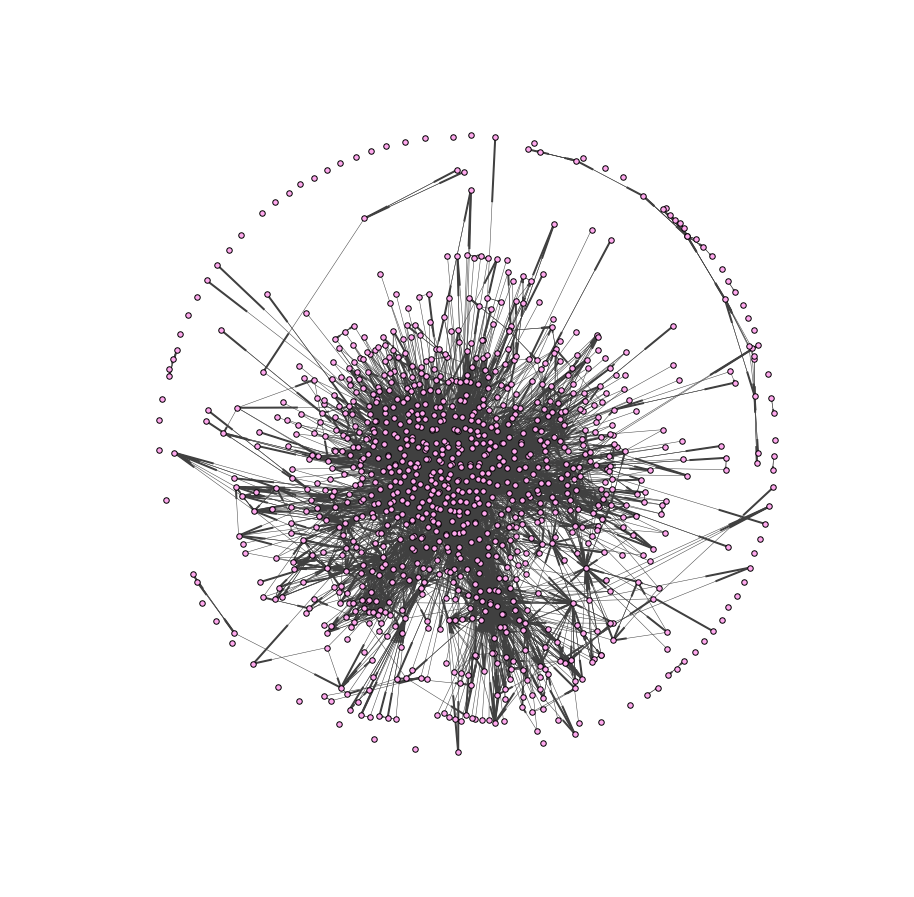

Network size : #nodes: 1062, #edges 7985


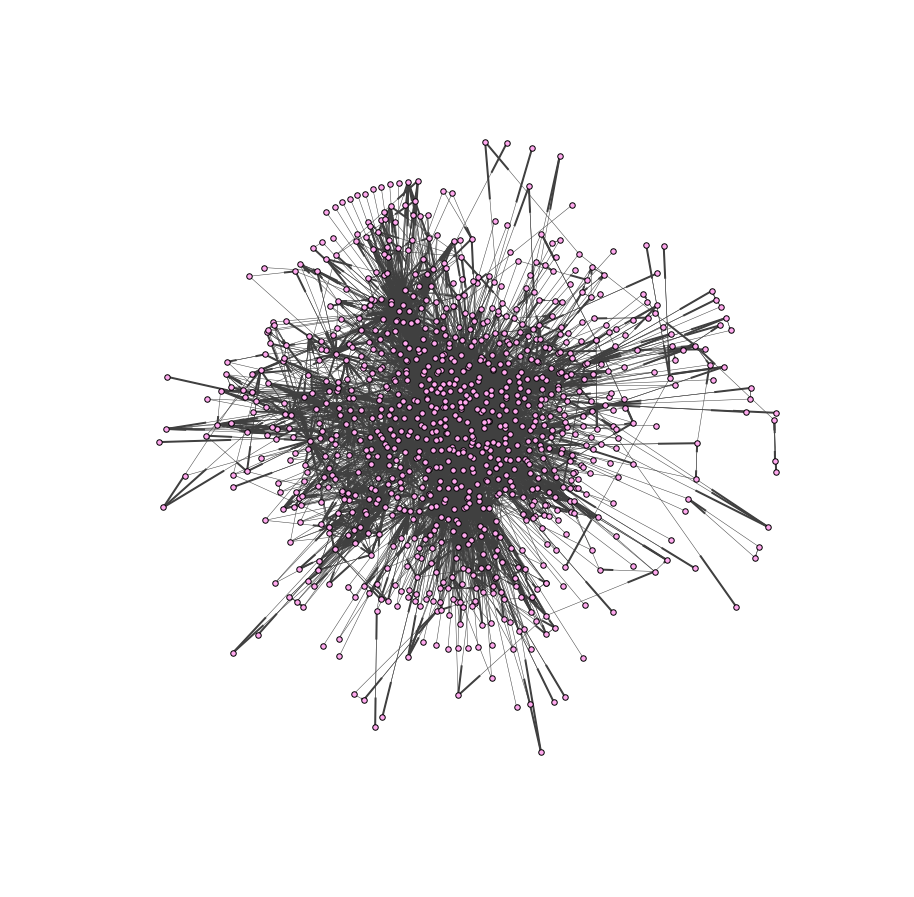

Network size : #nodes: 972, #edges 7907


In [6]:
G, G_wcc = createGoTNetwork(characters)
printNetworks(G, G_wcc)

## Network statistics (Centrality etc.)
### Betweenness centrality
* What role do you imagine characters with high graph betweenness centrality play in the series?

### Eigenvector centrality
* What role do you imagine characters with high graph eigenvector centrality play in the series?

In [7]:
top = 10
deg_table, bc_table, ec_table = printGraphStats(G_wcc, top=top)
print "The top %d GoT characters in terms of in-degree, out-degree and total degree (in + out degree):" %top
print deg_table
print "\nThe top %d Game of Thrones characters in terms of betweenness centrality:" % top   
print bc_table
print "\nThe top %d Game of Thrones characters in terms of eigenvector centrality (In degree and out degree)" % top
print ec_table

The top 10 GoT characters in terms of in-degree, out-degree and total degree (in + out degree):
+-------------------------+-------------------------+--------------------------+
|  Character - In degree  |  Character - Out degree | Character - Total degree |
+-------------------------+-------------------------+--------------------------+
|  Tyrion Lannister, 187  |   Tyrion Lannister, 63  |  Tyrion Lannister, 250   |
|      Jon Snow, 170      |       Jon Snow, 57      |      Jon Snow, 227       |
| Daenerys Targaryen, 146 |     Eddard Stark, 56    |    Eddard Stark, 195     |
|     Robb Stark, 146     |        Varys, 54        | Daenerys Targaryen, 192  |
|    Eddard Stark, 139    |    Catelyn Stark, 53    |   Jaime Lannister, 183   |
|   Jaime Lannister, 138  |    Petyr Baelish, 50    |     Robb Stark, 180      |
|     Sansa Stark, 128    |    Theon Greyjoy, 50    |     Sansa Stark, 174     |
|  Stannis Baratheon, 125 |   Cersei Lannister, 48  |  Cersei Lannister, 166   |
|  Joffrey Ba

In [16]:
print "The degree assortativity coefficient of the undirected philosopher graph is",nx.degree_assortativity_coefficient(H)

The degree assortativity coefficient of the undirected philosopher graph is -0.139557344134


**Definition: ** Positive values of *assortativity* indicate a correlation between nodes of smiliar degree, while negative values indicate relationships between nodes of different degree.

This means that high-degree characters does not tend to link to other high-degree characters. The same is true for low-degree characters. Instead there might be a bunch of low-degree characters that links to all the high-degree characters, i.e. the tendency is that a low-degree characters is more likely to link to a high-degree characters.

Network statistics:
* Plot the distribution of in-degrees and out-degrees, binned using numpy.histogram. What is the most common degree?

33


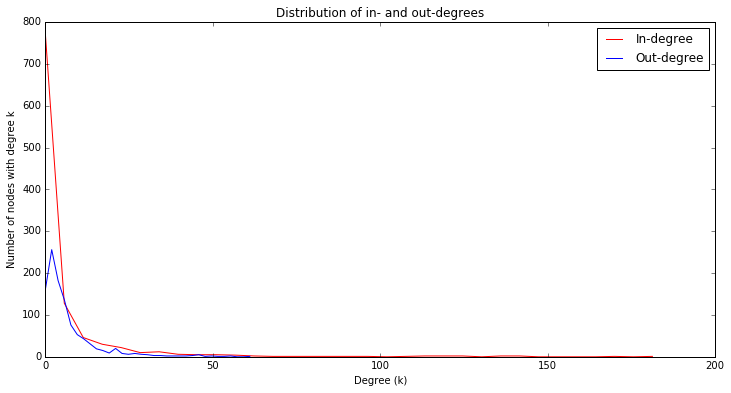

In [158]:
degreeDistPlots(G)

* Plot the distribution of in-degrees and out-degrees one more time, this time plotted loglog scale.

33


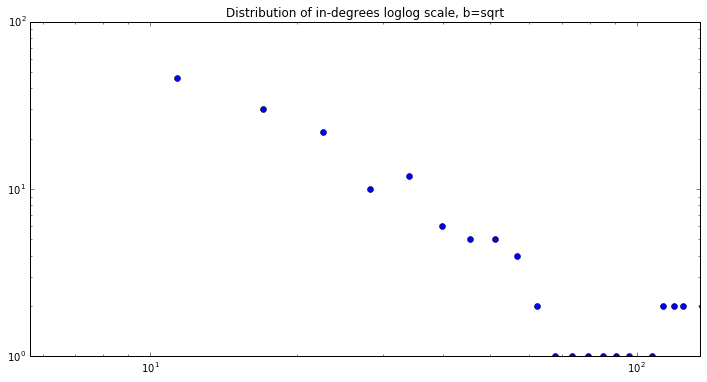

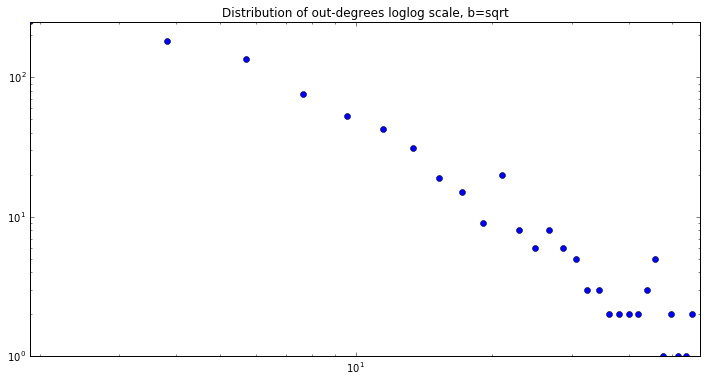

In [157]:
degreeDistPlots(G, loglog=True)

* Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?

* Plot a scatter plot of the the in- versus out- degree for all philosophers using a loglog scale. 

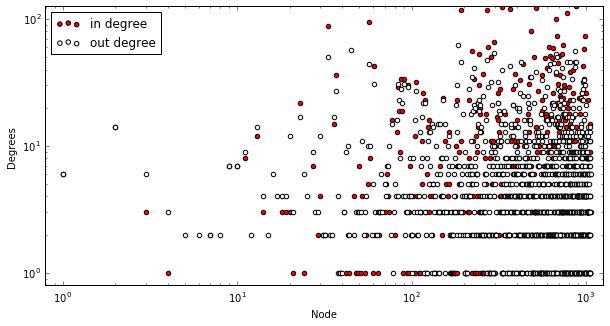

In [161]:
degreeScatterPlot(G)

*Comment on the relation between the two.*

## Part B: The branches of philosophy. Are they communities?
* Explain the concept of modularity in your own words.
* Now we will calculate the modularity of the branches reported by the Wikipedia editors. But we need to do a bit of work to make this happen.

* We can calculate the modularity, described in the Network Science book, section 9.4). Use equation 9.12 in the book to calculate the modularity M of the branches-partitioning.
* Comment on the value of M. Are the branches good communities? (We will explore this question in depth below.)

**Equation 9.12:**
$$M=\sum\limits_{c=1}^{n_c}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2 \right]$$

$n_c$: Number of communities  
$L_c$: The total number of links within the community $C_c$  
$k_c$: The total degree of the nodes in the community $C_c$  
A node's *total degree*, $k_i$ is given by: $k_i=k_i^{in}+k_i^{out}$

In [165]:
houses = calculateHouseModularity(getHouses(4))
print houseModularityTable(houses),'\n'
print "Modularity M =", sum([v['M'] for v in houses.values()])


+--------------------+-----+------+---------+
|       House        | L_c | k_c  |   M_c   |
+--------------------+-----+------+---------+
|  House Hightower   |  1  |  73  | 0.00013 |
|  House Lannister   |  67 | 1055 | 0.00358 |
|   Night's Watch    |  48 | 478  | 0.00624 |
|   House Martell    |  48 | 307  | 0.00710 |
|   House Greyjoy    |  38 | 295  | 0.00554 |
|     House Frey     |  19 | 166  | 0.00287 |
| Faith of the Seven |  10 |  87  | 0.00156 |
|    House Stark     | 124 | 1529 | 0.00484 |
|  House Baratheon   |  4  | 164  | 0.00047 |
|    House Tully     |  18 | 365  | 0.00203 |
|    House Tyrell    |  14 | 235  | 0.00189 |
|  House Targaryen   | 256 | 1364 | 0.02912 |
|    House Arryn     |  5  | 107  | 0.00073 |
+--------------------+-----+------+---------+ 

Modularity M = 0.0661049402429


# COMMENT ON MODULARITY VALUE!

## Part C: Community detection in the GoT network
* Use the [Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities in the full philosopher network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?
* [Note: This implementation is now available as Anaconda package. Install with conda as expained here].
* You can also try the Infomap algorithm instead if you're curious. Go to [this page](http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.
* Compare the communities found by your algorithm with the branches of philosophy by creating a matrix D with dimension (B times C), where B is the number of branches and C is the number of communities. We set entry D(i,j) to be the number of nodes that branch i has in common with community j. The matrix D is what we call a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy.


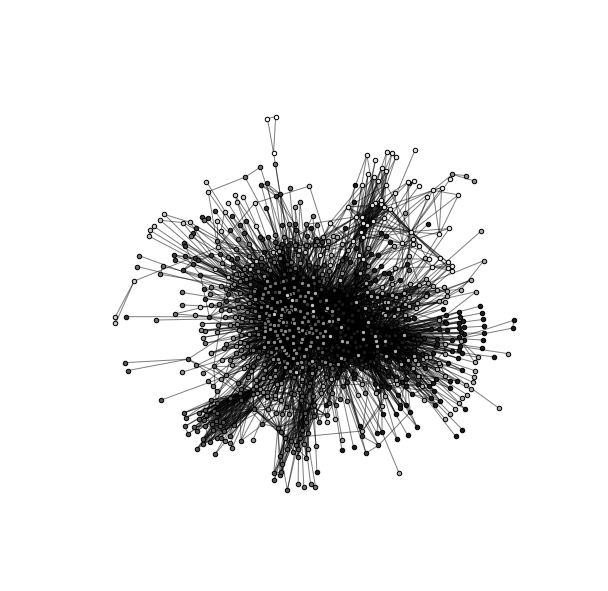

In [177]:
H = G_wcc.to_undirected()
showCommunityGraph(H)

In [174]:
D = calculateConfusionMatrix(H)
print D

Modularity of the GoT network: 0.492082275876
The algorithm found 8 communities in the graph.
[[  0.   0.   2.   8.   4.   1.   1.   0.]
 [ 24.   3.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   3.  15.   0.   0.   0.   0.]
 [ 13.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.  10.   0.   0.   0.]
 [  0.   0.   1.   5.   0.   0.   1.   0.]
 [ 12.   6.   1.   3.   5.   0.   0.   0.]
 [  0.   0.   0.   0.   5.   0.   1.   0.]
 [  0.   0.   0.   6.   0.   0.   0.   0.]
 [  0.   0.  34.   0.   0.  10.   2.   0.]
 [  0.   0.   1.   0.   5.   1.   0.   0.]]


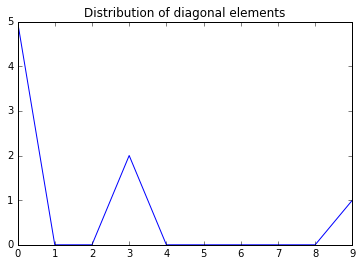

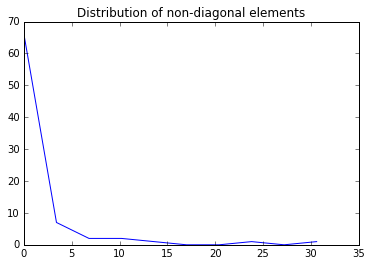

In [183]:
confusionMatrixDist(D)

**How do you use the confusion matrix to explain how well the communities I've detected correspond to the labeled houses in GoT?**

If the distribution of the *diagonal* elements are skewed to the right and the distribution of all other elements are skewed to the left, it could indicate that the communities are well-defined, as they do not have many links between them

# Twitter

In [42]:
from twitter import *

CONSUMER_KEY = '3K3riI9GkBsgmEHcU7SdIOCis'
CONSUMER_SECRET = 'vSDSYscimYUz3mXY2ozTsFLmOqkokzSVryD6WSlIAUovcFWp6v'
OAUTH_TOKEN = '390606166-2vuMgj39YuN0VOTQ2mDeJG9xpwuxDcnO5m0GqJrU'
OAUTH_TOKEN_SECRET = 'GysUmn3f4D8dnsW8BNtdxGZ36b3qKMK1G11ayEkbFWDf0'

# access the twitter API.
twitter_api = Twitter(auth=OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

# print help(Twitter)
tweets = twitter_api.search.tweets(q="Daenerys%20Targaryen",count='100', lang="en")

In [52]:
characterTweets = dict()
# for char in characters:
#     characterTweets[char] = list()
#     tweets = twitter_api.search.tweets(q=char, count="100", lang="en")
print tweets['statuses'][0].keys()
print tweets['statuses'][0]['in_reply_to_user_id_str'], tweets['statuses'][0]['in_reply_to_user_id'], tweets['statuses'][0]['in_reply_to_status_id'], tweets['statuses'][0]['text']
# for tweet in tweets['statuses']:
#     if tweet['in_reply_to_status_id'] == None:
#         print tweet['retweet_count'], tweet['id'], tweet['text']
# break

[u'contributors', u'truncated', u'text', u'is_quote_status', u'in_reply_to_status_id', u'id', u'favorite_count', u'entities', u'retweeted', u'coordinates', u'source', u'in_reply_to_screen_name', u'in_reply_to_user_id', u'retweet_count', u'id_str', u'favorited', u'retweeted_status', u'user', u'geo', u'in_reply_to_user_id_str', u'lang', u'created_at', u'in_reply_to_status_id_str', u'place', u'metadata']
None None None RT @gameofthronestv: 'Game of Thrones' Season 7 Latest Update: Jon Snow Confesses Love To Daenerys Targaryen; Death Match… https://t.co/0n5…
